# CSE 252B: Computer Vision II, Winter 2020 – Assignment 1
### Instructor: Ben Ochoa
### Due: Wednesday, January 15, 2020, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* All solutions must be written in this notebook.
* Math must be done in Markdown/LaTeX.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. If you are uncertain about using a specific package, then please ask the instructional staff whether or not it is allowable.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

# Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the five-point
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Förstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e., the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e., corners) in each image.

#### Display figures for:
 * minor eigenvalue images before thresholding
 * minor eigenvalue images after thresholding
 * original images with detected features

A typical implementation takes around 30 seconds to run. If yours takes more than 120 seconds, you may lose points.

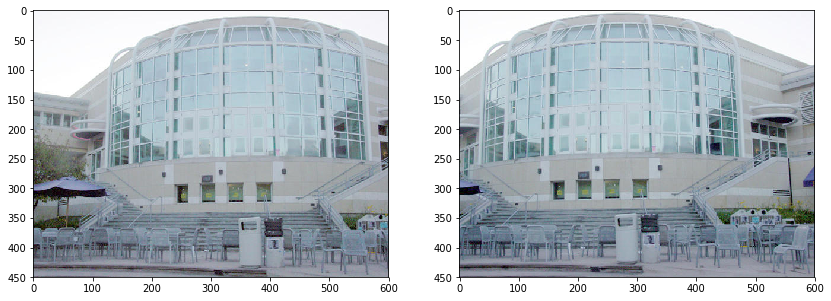

(450, 600, 3)


In [3]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time


# open the input images
I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()
print(I1.shape)

In [4]:
from scipy.signal import convolve
def ImageGradient(I):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    
    m, n = I.shape[:2]
    def rgb2gray(rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray
    
    if len(I.shape) == 3:
        I = rgb2gray(I)
    """your code here"""
    kernel = (1.0/12)*np.array([[-1,8,0,-8,1]]).T
    Ix = convolve(I, kernel.T, mode='same') 
    Iy = convolve(I, kernel, mode='same') 
    return Ix, Iy

def MinorEigenvalueImage(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding
    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    _w = int(w//2)
    bigN = np.zeros((m,n,2,2))
    bigB = np.zeros((m,n,2,1))
    b1 = np.zeros((m,n))
    b2 = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            b1[i][j] = j * Ixx[i][j] + i * Ixy[i][j]
            b2[i][j] = j * Ixy[i][j] + i * Iyy[i][j]
    
    #Calculate your minor eigenvalue image J0.
    """your code here"""
    for i in range(_w,m-_w):
        for j in range(_w,n-_w):
            N = np.zeros((2,2))
            N[0,0] = np.sum(Ixx[i-_w:i+_w+1,j-_w:j+_w+1]) 
            N[1,1] = np.sum(Iyy[i-_w:i+_w+1,j-_w:j+_w+1]) 
            tmp = np.sum(Ixy[i-_w:i+_w+1,j-_w:j+_w+1])
            N[0,1] = N[1,0] = tmp
            bigN[i,j,:,:] = N
            bigB[i,j,0,0] = np.sum(b1[i-_w:i+_w+1,j-_w:j+_w+1]) 
            bigB[i,j,1,0] = np.sum(b2[i-_w:i+_w+1,j-_w:j+_w+1]) 
            trace = np.matrix.trace(N)
            lambd = (trace - np.sqrt(trace**2 - 4*np.linalg.det(N)))/2
            J0[i,j] = lambd
    return J0,bigN,bigB
  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    J2 = J.copy()
    """your code here"""
    m,n = J.shape[:2]
    _w = w_nms //2
    for i in range(m):
        for j in range(n):
            up = max(0,i-_w)
            down = min(i+_w,m-1)
            left = max(0,j-_w)
            right = min(j+_w,n-1)
            _max = np.max(J[up:down+1,left:right+1])
            if _max > J[i,j]:
                J2[i,j] = 0
    return J2
  
def ForstnerCornerDetector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    """your code here"""
    J0, bigN, bigB = MinorEigenvalueImage(Ix, Iy, w)
    #print("finished MinorEigenvalueImage")
    J1 = J0.copy()
    J1[J1<t] = 0
    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = NMS(J1, w_nms)

    #Detect corners.
    """your code here"""
    b1 = np.zeros((m,n))
    b2 = np.zeros((m,n))
    C = 0
    corners = []
    for i in range(m):
        for j in range(n):
            if J2[i,j] > 0:
                C += 1
                corner = np.dot(np.linalg.inv(bigN[i,j,:,:]),bigB[i,j,:,:])
                corners.append(corner)
    pts = np.zeros((2,len(corners)))
    for i in range(len(corners)):
        pts[1,i] = corners[i][0]
        pts[0,i] = corners[i][1]
    print("finished ForstnerCornerDetection")
    return C, pts, J0, J1, J2

# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    Ix, Iy = ImageGradient(I)
    C, pts, J0, J1, J2 = ForstnerCornerDetector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

In [5]:
#Tuning Parameters
I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.

_w = [9]
_w_nms = [9]
_t = [0.01]

for w in _w:
    for w_nms in _w_nms:
        for t in _t:
            C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
            C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
            #print("w:{}, w_nms:{}, t:{}, # of points:{} {}".format(w,w_nms,t,C1,C2))


/Users/tommyhuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt
/Users/tommyhuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in less


finished ForstnerCornerDetection
finished ForstnerCornerDetection


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in sqrt
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in less


finished ForstnerCornerDetection
finished ForstnerCornerDetection
took 27.898536 secs


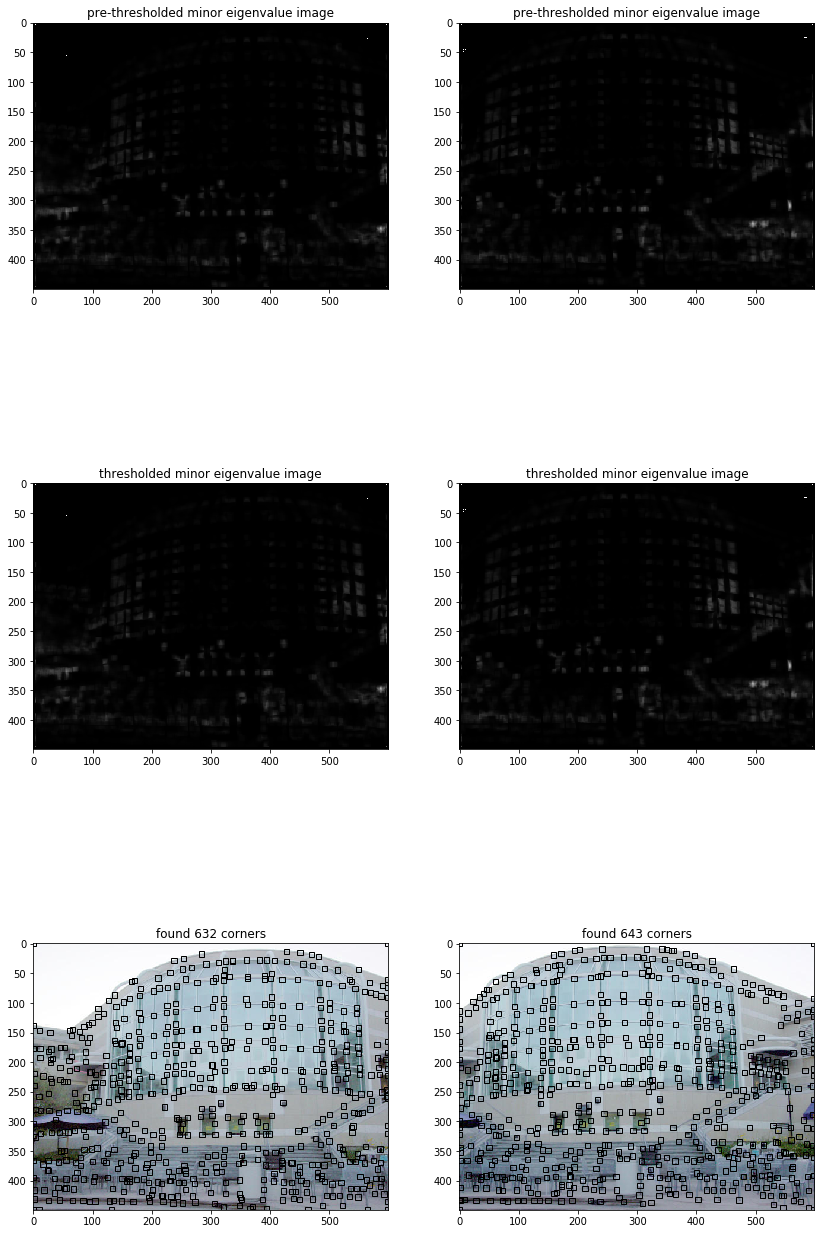

In [214]:
# input images
I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.

# parameters to tune
w = 9
t = 0.01
w_nms = 9

tic = time.time()
# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded minor eigenvalue images
plt.subplot(3,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')
plt.subplot(3,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')

# show thresholded minor eigenvalue images
plt.subplot(3,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')
plt.subplot(3,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')

# show corners on original images
ax = plt.subplot(3,2,5)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    # Note below that the y-intercept comes first. This is because
    # the images are stored as matrices, which are indexed as
    # (column,row).
    y,x = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('found %d corners'%C1)

ax = plt.subplot(3,2,6)
plt.imshow(I2)
for i in range(C2):
    # Note below that the y-intercept comes first. This is because
    # the images are stored as matrices, which are indexed as
    # (column,row).
    y,x = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 9
* t = 0.01
* w_nms = 9
* C1 = 632
* C2 = 643

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 200 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e., matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature

A typical implementation takes around 10 seconds to run. If yours takes more than 120 seconds, you may lose points.


In [360]:
def NCC(I1, I2, pts1, pts2, w,p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    """your code here"""
    #pts:(y,x)
    C1 = pts1.shape[1]
    C2 = pts2.shape[1]
    I1_gray = rgb2gray(I1)
    I2_gray = rgb2gray(I2)
    m,n = I1_gray.shape
    w = int(w//2)
    scores = np.zeros((C1,C2))
    for c1 in range(C1):
        for c2 in range(C2):
            y1,x1 = int(pts1[:,c1][0]),int(pts1[:,c1][1])
            y2,x2 = int(pts2[:,c2][0]),int(pts2[:,c2][1])
            if y1-w<0 or y1+w>m-1 or x1-w<0 or x1+w>n-1 or y2-w<0 
                                    or y2+w>m-1 or x2-w<0 or x2+w>n-1:
                continue
            if np.sqrt((y1-y2)**2+ (x1-x2)**2) > p:
                continue
            patch1 = I1_gray[y1-w:y1+w+1,x1-w:x1+w+1]
            patch2 = I2_gray[y2-w:y2+w+1,x2-w:x2+w+1]
            mean1 = np.mean(patch1)
            mean2 = np.mean(patch2)
            up1 = patch1-mean1
            up2 = patch2-mean2
            down1 = np.sqrt(np.sum(up1**2))
            down2 = np.sqrt(np.sum(up2**2))
            s1 = up1/down1
            s2 = up2/down2
            scores[c1][c2] = np.sum(s1*s2)
            #print(scores[c1][c2] )
    print("NCC finished")
    return scores


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # output:
    # list of the feature coordinates in image 1 and image 2 
    
    """your code here"""
    inds = []
    m,n = scores.shape
    best = np.max(scores)
    i,j = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
    
    mask = np.ones((m,n), dtype = bool)
    while best > t:
        scores[i][j] = -1
        nextbest_row = np.max(scores[i,:])
        nextbest_col = np.max(scores[:,j])
        nextbest = max(nextbest_row,nextbest_col)
        idx = np.where(scores == nextbest)
        next_i = idx[0][0]
        next_j = idx[1][0]
        scores[i][j] = best
        if (1-best) < (1-nextbest) * d:
            inds.append((i,j))
        for ii in range(m):
            mask[ii,j] = False
        for jj in range(n):
            mask[i,jj] = False
        best = np.max(scores)
        i,j = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
        while mask[i][j] == False:
            scores[i][j] = -1
            best = np.max(scores)
            i,j = np.unravel_index(np.argmax(scores, axis=None), scores.shape)

    print("finished Matching")
    return np.array(inds).T

def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w,p)
    inds = Match(scores, t, d)
    return inds



NCC finished
finished Matching
took 7.173153 secs
shape of inds: (2, 203)


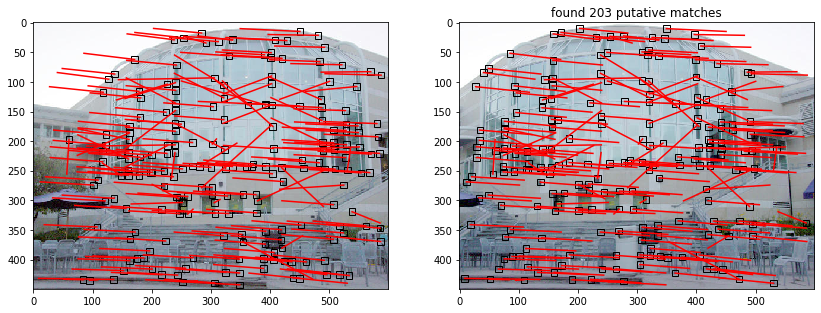

unique points in image 1: 203
unique points in image 2: 203


In [374]:
# parameters to tune
w = 11
t = 0.8
d = 0.9
p = 170

I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.
tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
print("shape of inds: {}".format(inds.shape))
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    y1,x1 = match1[:,i]
    y2,x2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 11
* t = 0.8 
* d = 0.9
* p = 170
* num_matches = 203